## 01. Import libraries

In [ ]:
# !pip install xgboost scikit-learn matplotlib --quiet

import zipfile, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier, plot_importance
import joblib

## 02. Extract dataset

In [ ]:
zip_path = '/content/playground-series-s4e11.zip'
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## 03. Load CSVs

In [ ]:
train_df = pd.read_csv(os.path.join(extract_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(extract_path, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(extract_path, 'sample_submission.csv'))

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (140700, 20)
Test shape: (93800, 19)


## 04. Encode target column

In [ ]:
target_col = 'Depression'
id_col = 'id'

if train_df[target_col].dtype == 'object':
    y = (train_df[target_col] == 'Yes').astype(int)
else:
    y = train_df[target_col]

## 05. Combine train + test for consistent encoding

In [ ]:
full_df = pd.concat([train_df.drop(columns=[target_col]), test_df], axis=0)

## 06. Label encode categorical columns

In [ ]:
categorical_cols = full_df.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col != id_col]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    full_df[col] = le.fit_transform(full_df[col].astype(str))
    label_encoders[col] = le

## 07. Fill missing values with median

In [ ]:
full_df.fillna(full_df.median(numeric_only=True), inplace=True)

## 08. Separate X and X_test

In [ ]:
X = full_df.iloc[:len(train_df), :].copy()
X_test = full_df.iloc[len(train_df):, :].copy()

## 09. Stratified K-Fold without early stopping

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_model = None
best_acc = 0

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n🔁 Fold {fold + 1}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"Fold Accuracy: {acc:.4f}")

    if acc > best_acc:
        best_model = model
        best_acc = acc


🔁 Fold 1


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:13:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold Accuracy: 0.9393

🔁 Fold 2


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:13:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold Accuracy: 0.9376

🔁 Fold 3


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:13:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold Accuracy: 0.9403

🔁 Fold 4


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:13:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold Accuracy: 0.9413

🔁 Fold 5


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:13:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold Accuracy: 0.9398


## 10. Confusion Matrix

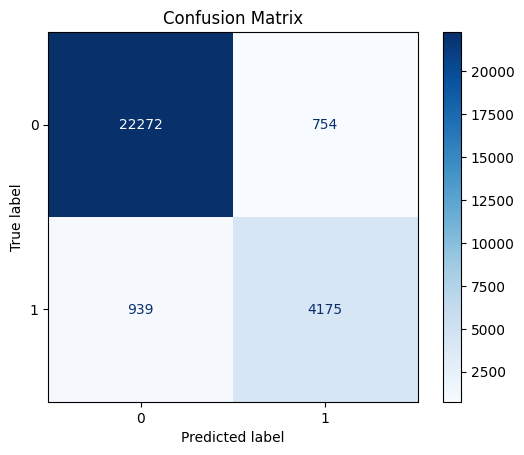

In [ ]:
conf_matrix = confusion_matrix(y_val, preds)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## 11. Feature Importance

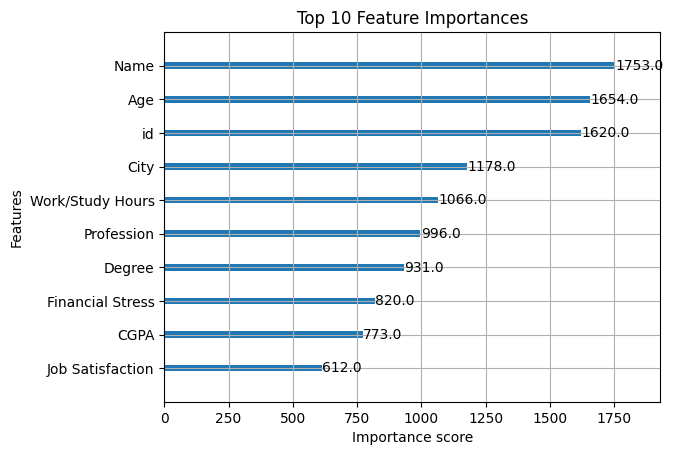

In [ ]:
plot_importance(best_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

## 12. Predict on test set

In [ ]:
final_preds = best_model.predict(X_test)

## 13. Save Submission

In [ ]:
submission = pd.DataFrame({
    'id': test_df[id_col],
    'target': final_preds
})
submission.to_csv('submission.csv', index=False)
print("✅ submission.csv saved!")

✅ submission.csv saved!
